In [1]:
import json
import sys
import os
from tqdm import tqdm
import pandas
import pandas as pd
import hashlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from datetime import datetime

# Function definition

In [13]:
def find_by_id(entry_id, collection):
    for entry in collection:
        if entry['_id']['$oid'] == entry_id:
            return entry
    return None

In [14]:
def get_interaction_keyword(interaction):
    for parameter in interaction['request']['endpoint']['parameters']:
        if parameter['name'] == 'keyword':
            return parameter['value']
    return None

In [15]:
def get_experiment_info(root_dir, experiment_id):
    run_directory = root_dir + '/' + experiment_id + '/mongo_data'
    with open(run_directory + '/experiments.json') as f:
        experiments = json.load(f)

    # There should be only one entry
    experiment_json = experiments[0]

    return experiment_json

In [16]:
def get_workers_info(run_dir, experiment_id):

    experiment_json = get_experiment_info(run_dir, experiment_id)

    columns = ['Module', 'Distance Field', 'Distance Type']

    ed_module = experiment_json['workers']['endpoint_detector_module']
    ed_module = ed_module.split('.')[2:]
    ed_module = '.'.join(e for e in ed_module)
    ed_field_for_distance = None
    ed_distance_type = None
    ed_entry = [ed_module, ed_field_for_distance, ed_distance_type]

    ec_module = experiment_json['workers']['endpoint_cleaner_module']
    ec_module = ec_module.split('.')[2:]
    ec_module = '.'.join(e for e in ec_module)
    ec_field_for_distance = experiment_json['endpoint_cleaner']['field_for_distance']
    ec_distance_type = experiment_json['endpoint_cleaner']['distance_type']
    ec_entry = [ec_module, ec_field_for_distance, ec_distance_type]

    scd_module = experiment_json['workers']['state_change_detector_module']
    scd_module = scd_module.split('.')[2:]
    scd_module = '.'.join(e for e in scd_module)
    scd_field_for_distance = experiment_json['state_change_detector']['field_for_distance']
    scd_distance_type = experiment_json['state_change_detector']['distance_type']
    scd_entry = [scd_module, scd_field_for_distance, scd_distance_type]

    sc_module = experiment_json['workers']['state_collapser_module']
    sc_module = sc_module.split('.')[2:]
    sc_module = '.'.join(e for e in sc_module)
    sc_field_for_distance = experiment_json['state_collapser']['field_for_distance']
    sc_distance_type = experiment_json['state_collapser']['distance_type']
    sc_entry = [sc_module, sc_field_for_distance, sc_distance_type]

    output = pd.DataFrame()
    output = output.append(pd.DataFrame(ed_entry).T)
    output = output.append(pd.DataFrame(ec_entry).T)
    output = output.append(pd.DataFrame(scd_entry).T)
    output = output.append(pd.DataFrame(sc_entry).T)
    output.columns = columns
    output = output.reset_index(drop=True)

    revisits = experiment_json['state_navigator']['max_revisits']
    return output, revisits

In [17]:
def get_experiment_config_md5(run_dir, experiment_id):
    full_str = ''
    output, revisits = get_workers_info(run_dir, experiment_id)
    for index, row in output.iterrows():
        for col in output.columns:
            full_str += str(row[col])

    md5_hash = hashlib.md5(full_str.encode())
    md5_hash_str = str(md5_hash.hexdigest())
    return md5_hash_str, revisits

In [18]:
def calculate_duration_seconds(interactions):
    if len(interactions) == 0:
        return 0

    ts_first = int(interactions[0]['created_at'])      # load timestamp as integer
    ts_first = datetime.fromtimestamp(ts_first//1000)  # parse as datetime

    ts_last = int(interactions[-1]['created_at'])
    ts_last = datetime.fromtimestamp(ts_last//1000)

    t_delta = ts_last - ts_first
    return t_delta.total_seconds()

In [19]:
states_baseline_causing_interaction_keyword_pairs = list()
states_baseline_causing_interaction_keyword_pairs.append({'previous':None, 'current':'state2_1'})
states_baseline_causing_interaction_keyword_pairs.append({'previous':None, 'current':'state2_2'})
states_baseline_causing_interaction_keyword_pairs.append({'previous':'state2_1', 'current':'state3_1'})
states_baseline_causing_interaction_keyword_pairs.append({'previous':'state2_1', 'current':'state3_2'})
states_baseline_causing_interaction_keyword_pairs.append({'previous':'state2_1', 'current':'state3_3'})
states_baseline_causing_interaction_keyword_pairs.append({'previous':'state2_1', 'current':'state3_4'})
states_baseline_causing_interaction_keyword_pairs.append({'previous':'state3_1', 'current':'special'})
states_baseline_causing_interaction_keyword_pairs.append({'previous':'special', 'current':'initial'})
state_count_baseline = len(states_baseline_causing_interaction_keyword_pairs)

In [20]:
def evaluate_experiment(experiment_directory):

    with open(experiment_directory + '/endpoints.json') as f:
        endpoints = json.load(f)

    with open(experiment_directory + '/interactions.json') as f:
        interactions = json.load(f)

    with open(experiment_directory + '/states.json') as f:
        states = json.load(f)

    with open(experiment_directory + '/experiments.json') as f:
        experiments = json.load(f)

    endpoint_count = len(endpoints)
    interaction_count = len(interactions)
    state_count = len(states)

    states_causing_interaction_keyword_pairs = list()
    for state in states:
        
        causing_interaction_id = state['caused_by_interaction_id']
        causing_interaction = find_by_id(entry_id=causing_interaction_id, collection=interactions)

        if causing_interaction:
            causing_interaction_keyword = get_interaction_keyword(causing_interaction)
        else:
            continue

        previous_state_id = state['previous_state_id']
        previous_state = find_by_id(entry_id=previous_state_id, collection=states)
        if previous_state:
            previous_causing_interaction_id = previous_state['caused_by_interaction_id']
            previous_causing_interaction = find_by_id(entry_id=previous_causing_interaction_id, collection=interactions)
            if previous_causing_interaction:
                previous_causing_interaction_keyword = get_interaction_keyword(previous_causing_interaction)
            else:
                previous_causing_interaction_keyword = None
        else:
            previous_causing_interaction_keyword = None

        keywords_pair = {'previous':previous_causing_interaction_keyword, 'current':causing_interaction_keyword}
        states_causing_interaction_keyword_pairs.append(keywords_pair)

    correctly_detected_states = 0
    for states_causing_interaction_keyword_pair in states_causing_interaction_keyword_pairs:
        if states_causing_interaction_keyword_pair in states_baseline_causing_interaction_keyword_pairs:
            correctly_detected_states += 1

    all_states_correct = False
    if correctly_detected_states == 8:
        all_states_correct = True

    duration_seconds = calculate_duration_seconds(interactions)

    return endpoint_count, interaction_count, state_count, correctly_detected_states, all_states_correct, duration_seconds

In [21]:
def gen_for_all(root_directory, runs):
    outputs = dict()
    for run in tqdm(runs):
        run_directory = f'{root_directory}/{run}'
        run_outputs = dict()

        # Load the data
        columns=['batch_name','endpoint_count', 'interaction_count', 'state_count', 'correct_states_count', 'all_states_correct','duration_seconds', 'revisits', 'config_md5']
        results = pd.DataFrame(columns=columns)

        experiments = os.listdir(run_directory)
        for experiment in experiments:
            experiment_dir = f"{run_directory}/{experiment}"
            if os.path.isdir(experiment_dir):
                endpoint_count, interaction_count, state_count, correctly_detected_states, all_states_correct, duration_seconds = evaluate_experiment(f'{experiment_dir}/mongo_data')
            config_md5, revisits = get_experiment_config_md5(run_directory, experiment)
            df_local = pd.DataFrame([experiment, endpoint_count, interaction_count, state_count, correctly_detected_states, all_states_correct, duration_seconds, revisits, config_md5]).T
            df_local.columns = columns
            results = results.append(df_local, ignore_index=True)

        results.duration_seconds = results.duration_seconds.astype(int)

        outputs[str(run)] = results
    return outputs

In [22]:
def plot_mean_data_clustering_based(data, column, title, y_lim='max', bar_offset=0):
    state_change_clustering_selection = data['StateChangeDetector'] == 'ClusteringBased.StateChangeDetector'
    state_change_clustering = data[state_change_clustering_selection]
    
    state_change_clustering_levenshtein_selection = data[state_change_clustering_selection]['StateChangeDetector_DT'] == 'levenshtein'
    state_change_clustering_levenshtein = data[state_change_clustering_selection][state_change_clustering_levenshtein_selection]
    
    state_change_clustering_tlsh_selection = data[state_change_clustering_selection]['StateChangeDetector_DT'] == 'tlsh'
    state_change_clustering_tlsh = data[state_change_clustering_selection][state_change_clustering_tlsh_selection]
    
    state_change_clustering_hash2vec_selection = data[state_change_clustering_selection]['StateChangeDetector_DT'] == 'hash2vec'
    state_change_clustering_hash2vec = data[state_change_clustering_selection][state_change_clustering_hash2vec_selection]
    
    bar_width = 0.2
    
    x_values = [0]
    position1 = [p - 1.5*bar_width for p in x_values]#[-0.3, 0.7]
    position2 = [p - 0.5*bar_width for p in x_values]#[-0.1, 0.9]
    position3 = [p + 0.5*bar_width for p in x_values]#[0.1, 1.1]
    position4 = [p + 1.5*bar_width for p in x_values]#[0.3,1.3]
    
    #fig.xticks([r + bar_width for r in range(number_of_x_values)], ['tlsh', 'hash2vec'])
    state_change_values = [
                           state_change_clustering_levenshtein,
                           state_change_clustering_tlsh,
                           state_change_clustering_hash2vec,
                           ]
    state_change_labels = [
                           "State Change Detection: Levenshtein Distance (DOM)",
                           "State Change Detection: TLSH Score (Hash)",
                           "State Change Detection: Euclidean Distance (Hash)",
                        ]

    fig = plt.figure(figsize=(20,5))
    fig.suptitle(title, fontsize=14, fontweight="bold")
    fig.subplots_adjust(hspace=0.4,wspace=0.3, top=0.85)
    for index, state_change_selection in enumerate(state_change_values):
        ax = fig.add_subplot(1,3,index+1)
    
        #ax.set_xticks(x_values, [0,1,10])
        ax.set_title(state_change_labels[index])
        ax.set_xlabel("Number of Revisits per Endpoint")
        ax.set_ylabel("Average count of correctly identified states")
        ax.grid(linestyle = '--', linewidth = 0.5, axis = 'y', zorder=0)
    
        select_hash2vec = state_change_selection['StateCollapser_DT'] == "hash2vec"
        select_tlsh = state_change_selection['StateCollapser_DT'] == "tlsh"
    
        # first: State Collapser, second: Endpoint Cleaner
        select_hash2vec_hash2vec = state_change_selection[select_hash2vec]['Endpoint_Cleaner_DT'] == "hash2vec"
        select_hash2vec_tlsh = state_change_selection[select_hash2vec]['Endpoint_Cleaner_DT'] == "tlsh"
        select_tlsh_hash2vec = state_change_selection[select_tlsh]['Endpoint_Cleaner_DT'] == "hash2vec"
        select_tlsh_tlsh = state_change_selection[select_tlsh]['Endpoint_Cleaner_DT'] == "tlsh"
        
        hash2vec_hash2vec_plot_data = state_change_selection[select_hash2vec][select_hash2vec_hash2vec].sort_values('revisits').groupby('revisits')[column].mean()
        hash2vec_hash2vec_plot_std = state_change_selection[select_hash2vec][select_hash2vec_hash2vec].sort_values('revisits').groupby('revisits')[column].std()
        
        hash2vec_tlsh_plot_data = state_change_selection[select_hash2vec][select_hash2vec_tlsh].sort_values('revisits').groupby('revisits')[column].mean()
        hash2vec_tlsh_plot_std = state_change_selection[select_hash2vec][select_hash2vec_tlsh].sort_values('revisits').groupby('revisits')[column].std()
        
        tlsh_hash2vec_plot_data = state_change_selection[select_tlsh][select_tlsh_hash2vec].sort_values('revisits').groupby('revisits')[column].mean()
        tlsh_hash2vec_plot_std = state_change_selection[select_tlsh][select_tlsh_hash2vec].sort_values('revisits').groupby('revisits')[column].std()
        
        tlsh_tlsh_plot_data = state_change_selection[select_tlsh][select_tlsh_tlsh].sort_values('revisits').groupby('revisits')[column].mean()
        tlsh_tlsh_std = state_change_selection[select_tlsh][select_tlsh_tlsh].sort_values('revisits').groupby('revisits')[column].std()
        
        configurations_sum = hash2vec_hash2vec_plot_data + hash2vec_tlsh_plot_data + tlsh_hash2vec_plot_data + tlsh_tlsh_plot_data
        configurations_mean = configurations_sum/4
        
        ax.bar(position1, hash2vec_hash2vec_plot_data, yerr=hash2vec_hash2vec_plot_std, align='center', capsize=6, zorder=3, width=bar_width, label ="State Colapser: Euclidean Distance (Hash) and Endpoint Cleaner: Eulidean Distance (Hash)")
        ax.bar(position2, hash2vec_tlsh_plot_data, yerr=hash2vec_tlsh_plot_std, align='center', capsize=6, zorder=3, width=bar_width, label ="State Colapser: Euclidean Distance (Hash) and Endpoint Cleaner: TLSH Score (Hash)")
        ax.bar(position3, tlsh_hash2vec_plot_data, yerr=tlsh_hash2vec_plot_std, align='center', capsize=6, zorder=3, width=bar_width, label = "State Colapser: TLSH Score (Hash) and Endpoint Cleaner: Euclidean Distance (Hash)")
        ax.bar(position4, tlsh_tlsh_plot_data, yerr=tlsh_tlsh_std, align='center', capsize=6, zorder=3, width=bar_width, label ="State Colapser: TLSH Score and Endpoint Cleaner: TLSH Score")
        
        if y_lim == 'max':
            ax.set_ylim(0,max(all_runs_df[column]) + 1.5)
        else:
            ax.set_ylim(0,y_lim)
        
        #for container in ax.containers:
            #ax.bar_label(container)
            
        if index+1 == 2:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
              fancybox=True, shadow=True, ncol=1)
    plt.savefig(f'{title.lower().replace(" ", "_")}.png', bbox_inches='tight')
    plt.show()

In [23]:
def plot_mean_data_one_fig_clustering_based(data, column, title, y_lim='max', y_label = "", bar_offset = 0):
    bar_width = 0.2

    x_values = [0,1,2]
    position1 = [p - 1.5*bar_width for p in x_values]#[-0.3, 0.7]
    position2 = [p - 0.5*bar_width for p in x_values]#[-0.1, 0.9]
    position3 = [p + 0.5*bar_width for p in x_values]#[0.1, 1.1]
    position4 = [p + 1.5*bar_width for p in x_values]#[0.3,1.3]
    
    euclidean_str = "Euclidean"
    levenshtein_str = "Levenshtein"
    tlsh_str = "TLSH Score"

    fig, ax = plt.subplots()
    ax.set_xticks(x_values, [euclidean_str, tlsh_str, levenshtein_str])
    ax.set_title(title)
    ax.set_xlabel("StateChangeDetector")
    ax.set_ylabel(y_label)
    ax.grid(linestyle = '--', linewidth = 0.5, axis = 'y', zorder=0)

    select_hash2vec = data['StateCollapser_DT'] == "hash2vec"
    select_tlsh = data['StateCollapser_DT'] == "tlsh"

    # first: State Collapser, second: Endpoint Cleaner
    select_hash2vec_hash2vec = data[select_hash2vec]['Endpoint_Cleaner_DT'] == "hash2vec"
    select_hash2vec_tlsh = data[select_hash2vec]['Endpoint_Cleaner_DT'] == "tlsh"
    select_tlsh_hash2vec = data[select_tlsh]['Endpoint_Cleaner_DT'] == "hash2vec"
    select_tlsh_tlsh = data[select_tlsh]['Endpoint_Cleaner_DT'] == "tlsh"
    

    hash2vec_hash2vec_plot_data = data[select_hash2vec][select_hash2vec_hash2vec].sort_values('StateChangeDetector_DT').groupby('StateChangeDetector_DT')[column].mean()
    hash2vec_hash2vec_plot_std = data[select_hash2vec][select_hash2vec_hash2vec].sort_values('StateChangeDetector_DT').groupby('StateChangeDetector_DT')[column].std()
    hash2vec_hash2vec_plot_data = hash2vec_hash2vec_plot_data[['hash2vec', 'tlsh', 'levenshtein']]
    hash2vec_hash2vec_plot_std = hash2vec_hash2vec_plot_std[['hash2vec', 'tlsh', 'levenshtein']]

    hash2vec_tlsh_plot_data = data[select_hash2vec][select_hash2vec_tlsh].sort_values('StateChangeDetector_DT').groupby('StateChangeDetector_DT')[column].mean()
    hash2vec_tlsh_plot_std = data[select_hash2vec][select_hash2vec_tlsh].sort_values('StateChangeDetector_DT').groupby('StateChangeDetector_DT')[column].std()
    hash2vec_tlsh_plot_data = hash2vec_tlsh_plot_data[['hash2vec', 'tlsh', 'levenshtein']]
    hash2vec_tlsh_plot_std = hash2vec_tlsh_plot_std[['hash2vec', 'tlsh', 'levenshtein']]

    tlsh_hash2vec_plot_data = data[select_tlsh][select_tlsh_hash2vec].sort_values('StateChangeDetector_DT').groupby('StateChangeDetector_DT')[column].mean()
    tlsh_hash2vec_plot_std = data[select_tlsh][select_tlsh_hash2vec].sort_values('StateChangeDetector_DT').groupby('StateChangeDetector_DT')[column].std()
    tlsh_hash2vec_plot_data = tlsh_hash2vec_plot_data[['hash2vec', 'tlsh', 'levenshtein']]
    tlsh_hash2vec_plot_std = tlsh_hash2vec_plot_std[['hash2vec', 'tlsh', 'levenshtein']]

    tlsh_tlsh_plot_data = data[select_tlsh][select_tlsh_tlsh].sort_values('StateChangeDetector_DT').groupby('StateChangeDetector_DT')[column].mean()
    tlsh_tlsh_std = data[select_tlsh][select_tlsh_tlsh].sort_values('StateChangeDetector_DT').groupby('StateChangeDetector_DT')[column].std()
    tlsh_tlsh_plot_data = tlsh_tlsh_plot_data[['hash2vec', 'tlsh', 'levenshtein']]
    tlsh_tlsh_std = tlsh_tlsh_std[['hash2vec', 'tlsh', 'levenshtein']]

    ax.bar(position1, hash2vec_hash2vec_plot_data, yerr=hash2vec_hash2vec_plot_std, align='center', capsize=6, zorder=3, width=bar_width, label =f"StateDetector: {euclidean_str} | EndpointDetector: {euclidean_str}")
    ax.bar(position2, hash2vec_tlsh_plot_data, yerr=hash2vec_tlsh_plot_std, align='center', capsize=6, zorder=3, width=bar_width, label =f"StateDetector: {euclidean_str} | EndpointDetector: {tlsh_str}")
    ax.bar(position3, tlsh_hash2vec_plot_data, yerr=tlsh_hash2vec_plot_std, align='center', capsize=6, zorder=3, width=bar_width, label = f"StateDetector: {tlsh_str} | EndpointDetector: {euclidean_str}")
    ax.bar(position4, tlsh_tlsh_plot_data, yerr=tlsh_tlsh_std, align='center', capsize=6, zorder=3, width=bar_width, label =f"StateDetector: {tlsh_str} | EndpointDetector: {tlsh_str}")

    if y_lim == 'max':
        ax.set_ylim(0,max(all_runs_df[column]) + 1.5)
    else:
        ax.set_ylim(0,y_lim)

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
      fancybox=True, shadow=False, ncol=1)
    plt.axhline(8, color='black', linestyle="--")
    plt.savefig(f'{title.lower().replace(" ", "_")}.svg', bbox_inches='tight', format="svg")
    plt.show() 

In [24]:
def plot_mean_data_basic(data, column, title, y_lim='max', bar_offset=0):
    state_change_clustering_selection = data['StateChangeDetector'] == 'ClusteringBased.StateChangeDetector'
    state_change_clustering = data[state_change_clustering_selection]
    
    state_change_clustering_levenshtein_selection = data[state_change_clustering_selection]['StateChangeDetector_DT'] == 'levenshtein'
    state_change_clustering_levenshtein = data[state_change_clustering_selection][state_change_clustering_levenshtein_selection]
    
    state_change_clustering_tlsh_selection = data[state_change_clustering_selection]['StateChangeDetector_DT'] == 'tlsh'
    state_change_clustering_tlsh = data[state_change_clustering_selection][state_change_clustering_tlsh_selection]
    
    state_change_clustering_hash2vec_selection = data[state_change_clustering_selection]['StateChangeDetector_DT'] == 'hash2vec'
    state_change_clustering_hash2vec = data[state_change_clustering_selection][state_change_clustering_hash2vec_selection]
    
    bar_width = 0.2
    
    x_values = [0]
    position1 = [p - 1.5*bar_width for p in x_values]#[-0.3, 0.7]
    position2 = [p - 0.5*bar_width for p in x_values]#[-0.1, 0.9]
    position3 = [p + 0.5*bar_width for p in x_values]#[0.1, 1.1]
    position4 = [p + 1.5*bar_width for p in x_values]#[0.3,1.3]
    
    #fig.xticks([r + bar_width for r in range(number_of_x_values)], ['tlsh', 'hash2vec'])
    state_change_values = [
                           state_change_clustering_levenshtein,
                           state_change_clustering_tlsh,
                           state_change_clustering_hash2vec,
                           ]
    state_change_labels = [
                           "State Change Detection: Levenshtein Distance (DOM)",
                           "State Change Detection: TLSH Score (Hash)",
                           "State Change Detection: Euclidean Distance (Hash)",
                        ]

    fig = plt.figure(figsize=(20,5))
    fig.suptitle(title, fontsize=14, fontweight="bold")
    fig.subplots_adjust(hspace=0.4,wspace=0.3, top=0.85)
    for index, state_change_selection in enumerate(state_change_values):
        ax = fig.add_subplot(1,3,index+1)
    
        #ax.set_xticks(x_values, [0,1,10])
        ax.set_title(state_change_labels[index])
        ax.set_xlabel("Number of Revisits per Endpoint")
        ax.set_ylabel("Average count of correctly identified states")
        ax.grid(linestyle = '--', linewidth = 0.5, axis = 'y', zorder=0)
    
        select_hash2vec = state_change_selection['StateCollapser_DT'] == "hash2vec"
        select_tlsh = state_change_selection['StateCollapser_DT'] == "tlsh"
        
        hash2vec_plot_data = state_change_selection[select_hash2vec].sort_values('revisits').groupby('revisits')[column].mean()
        hash2vec_std = state_change_selection[select_hash2vec].sort_values('revisits').groupby('revisits')[column].std()
        
        tlsh_plot_data = state_change_selection[select_tlsh].sort_values('revisits').groupby('revisits')[column].mean()
        tlsh_std = state_change_selection[select_tlsh].sort_values('revisits').groupby('revisits')[column].std()
        
        configurations_sum = hash2vec_plot_data + tlsh_plot_data
        configurations_mean = configurations_sum/2
        
        ax.bar(position1, hash2vec_plot_data, yerr=hash2vec_std, align='center', capsize=6, zorder=3, width=bar_width, label ="State Colapser: Euclidean Distance (Hash)")
        ax.bar(position2, tlsh_plot_data, yerr=tlsh_std, align='center', capsize=6, zorder=3, width=bar_width, label ="State Colapser: TLSH Score (Hash)")
        #ax.bar(position3, tlsh_hash2vec_plot_data, yerr=tlsh_hash2vec_plot_std, align='center', capsize=6, zorder=3, width=bar_width, label = "State Colapser: TLSH Score (Hash) and Endpoint Cleaner: Euclidean Distance (Hash)")
        #ax.bar(position4, tlsh_tlsh_plot_data, yerr=tlsh_tlsh_std, align='center', capsize=6, zorder=3, width=bar_width, label ="State Colapser: TLSH Score and Endpoint Cleaner: TLSH Score")
        
        if y_lim == 'max':
            ax.set_ylim(0,max(all_runs_df[column]) + 1.5)
        else:
            ax.set_ylim(0,y_lim)
        
        #for container in ax.containers:
            #ax.bar_label(container)
            
        if index+1 == 2:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
              fancybox=True, shadow=True, ncol=1)
    plt.savefig(f'{title.lower().replace(" ", "_")}.png', bbox_inches='tight')
    plt.show()

In [25]:
def plot_mean_data_one_fig_basic(data, column, title, y_lim='max', y_label = "", bar_offset = 0):
    bar_width = 0.2

    x_values = [0,0.5,1]
    position1 = [p - 1.5*bar_width for p in x_values]#[-0.3, 0.7]
    position2 = [p - 0.5*bar_width for p in x_values]#[-0.1, 0.9]
    position3 = [p + 0.5*bar_width for p in x_values]#[0.1, 1.1]
    position4 = [p + 1.5*bar_width for p in x_values]#[0.3,1.3]

    euclidean_str = "Euclidean"
    levenshtein_str = "Levenshtein"
    tlsh_str = "TLSH Score"

    fig, ax = plt.subplots(figsize = (6,3))
    ax.set_xticks(x_values, [euclidean_str, tlsh_str, levenshtein_str])
    ax.set_title(title)
    ax.set_xlabel("StateChangeDetector")
    ax.set_ylabel(y_label)
    ax.grid(linestyle = '--', linewidth = 0.5, axis = 'y', zorder=0)

    select_hash2vec = data['StateCollapser_DT'] == "hash2vec"
    select_tlsh = data['StateCollapser_DT'] == "tlsh"
    
    hash2vec_plot_data = data[select_hash2vec].sort_values('StateChangeDetector_DT').groupby('StateChangeDetector_DT')[column].mean()
    hash2vec_plot_std = data[select_hash2vec].sort_values('StateChangeDetector_DT').groupby('StateChangeDetector_DT')[column].std()
    hash2vec_plot_data = hash2vec_plot_data[['hash2vec', 'tlsh', 'levenshtein']]
    hash2vec_plot_std = hash2vec_plot_std[['hash2vec', 'tlsh', 'levenshtein']]
    
    tlsh_plot_data = data[select_tlsh].sort_values('StateChangeDetector_DT').groupby('StateChangeDetector_DT')[column].mean()
    tlsh_plot_std = data[select_tlsh].sort_values('StateChangeDetector_DT').groupby('StateChangeDetector_DT')[column].std()
    tlsh_plot_data = tlsh_plot_data[['hash2vec', 'tlsh', 'levenshtein']]
    tlsh_plot_std = tlsh_plot_std[['hash2vec', 'tlsh', 'levenshtein']]

    ax.bar(position2, hash2vec_plot_data, yerr=hash2vec_plot_std, align='center', capsize=6, zorder=3, width=bar_width, label =f"StateDetector: {euclidean_str}")
    ax.bar(position3, tlsh_plot_data, yerr=tlsh_plot_std, align='center', capsize=6, zorder=3, width=bar_width, label =f"StateDetector: {tlsh_str}")
    #ax.bar(position3, tlsh_hash2vec_plot_data, yerr=tlsh_hash2vec_plot_std, align='center', capsize=6, zorder=3, width=bar_width, label = f"StateDetector: {tlsh_str} | EndpointDetector: {euclidean_str}")
    #ax.bar(position4, tlsh_tlsh_plot_data, yerr=tlsh_tlsh_std, align='center', capsize=6, zorder=3, width=bar_width, label =f"StateDetector: {tlsh_str} | EndpointDetector: {tlsh_str}")

    if y_lim == 'max':
        ax.set_ylim(0,max(all_runs_df[column]) + 1.5)
    else:
        ax.set_ylim(0,y_lim)

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
      fancybox=True, shadow=False, ncol=2)
    plt.axhline(8, color='black', linestyle="--")
    plt.savefig(f'{title.lower().replace(" ", "_")}_no_ec.svg', bbox_inches='tight', format="svg")
    plt.show() 

In [26]:
def calculate_mean_data(data, column, module_column, module_name):
    clustering_module_selection = data[module_column] == module_name
    
    clustering_module_levenshtein_selection = data[clustering_module_selection][f'{module_column}_DT'] == 'levenshtein'
    clustering_module_levenshtein = data[clustering_module_selection][clustering_module_levenshtein_selection]
    
    clustering_module_tlsh_selection = data[clustering_module_selection][f'{module_column}_DT'] == 'tlsh'
    clustering_module_tlsh = data[clustering_module_selection][clustering_module_tlsh_selection]
    
    clustering_module_hash2vec_selection = data[clustering_module_selection][f'{module_column}_DT'] == 'hash2vec'
    clustering_module_hash2vec = data[clustering_module_selection][clustering_module_hash2vec_selection]
    
    
    module_values = [clustering_module_levenshtein,
                     clustering_module_tlsh,
                     clustering_module_hash2vec]
    
    output = []
        
    for index, module_selection in enumerate(module_values):
        output.append(module_selection[column].mean())
        
    return output

# Define root folder of evaluation data

In [29]:
root_directory = "**path to the evaluation data**"
run_count = 20

# Clustering Based Endpoint Detector Experiments

In [30]:
experiments_dir = root_directory + '/Clustering Based ED Experiments'
all_runs_eval = gen_for_all(experiments_dir, range(run_count))

  0%|                                                    | 0/20 [00:00<?, ?it/s]


NameError: name 'datetime' is not defined

## Tabular Representation of Results

In [8]:
# Creating one big picture

# Data generation

columns = [
    "EndpointDetector", "EndpointDetector_DF", "EndpointDetector_DT",
    "Endpoint_Cleaner", "Endpoint_Cleaner_DF", "Endpoint_Cleaner_DT",
    "StateChangeDetector", "StateChangeDetector_DF", "StateChangeDetector_DT",
    "StateCollapser", "StateCollapser_DF", "StateCollapser_DT",
]

all_runs_list = []
columns_combined = all_runs_eval['0'].columns.values.tolist() + columns
all_runs_df = pd.DataFrame(columns=columns_combined)
for run, eval_data in all_runs_eval.items():
    all_results_reshaped = pd.DataFrame(columns = columns_combined)
    for index, experiment in eval_data.iterrows():
        run_directory = f"{experiments_dir}/{run}"
        config, revisits = get_workers_info(run_directory, str(experiment.batch_name))
        config_reshaped = pandas.DataFrame(columns=columns_combined)
        tmp_dict = experiment.to_dict()
        for i, row in config.iterrows():
            tmp_dict[columns[i*3]] = row['Module']
            tmp_dict[columns[i*3+1]] = row['Distance Field']
            tmp_dict[columns[i*3+2]] = row['Distance Type']
        config_reshaped = config_reshaped.append(tmp_dict, ignore_index=True)
        all_results_reshaped = all_results_reshaped.append(config_reshaped, ignore_index=True)
    all_runs_list.append(all_results_reshaped)
    all_runs_df = all_runs_df.append(all_results_reshaped)

NameError: name 'all_runs_eval' is not defined

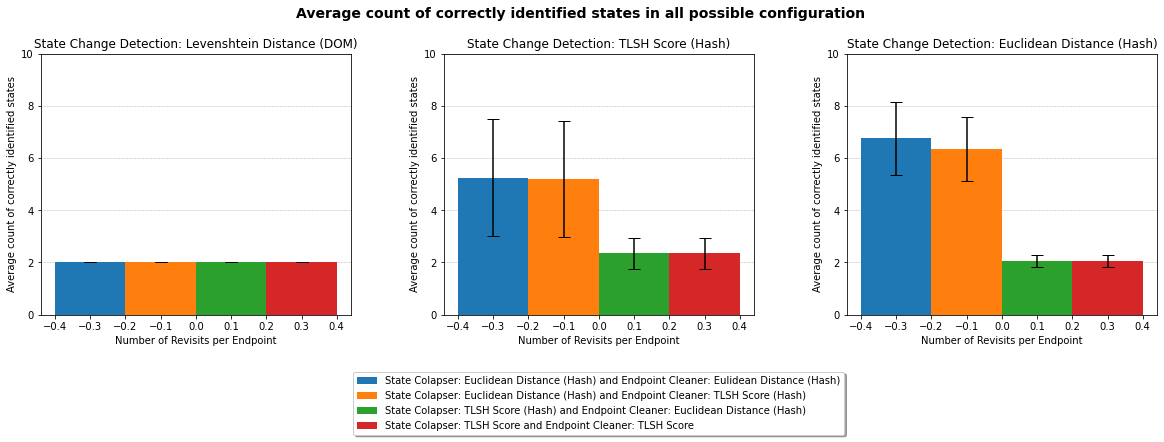

In [19]:
plot_mean_data_clustering_based(data=all_runs_df, 
               column='correct_states_count', 
               y_lim=10,
               bar_offset=0.04,
               title='Average count of correctly identified states in all possible configuration')

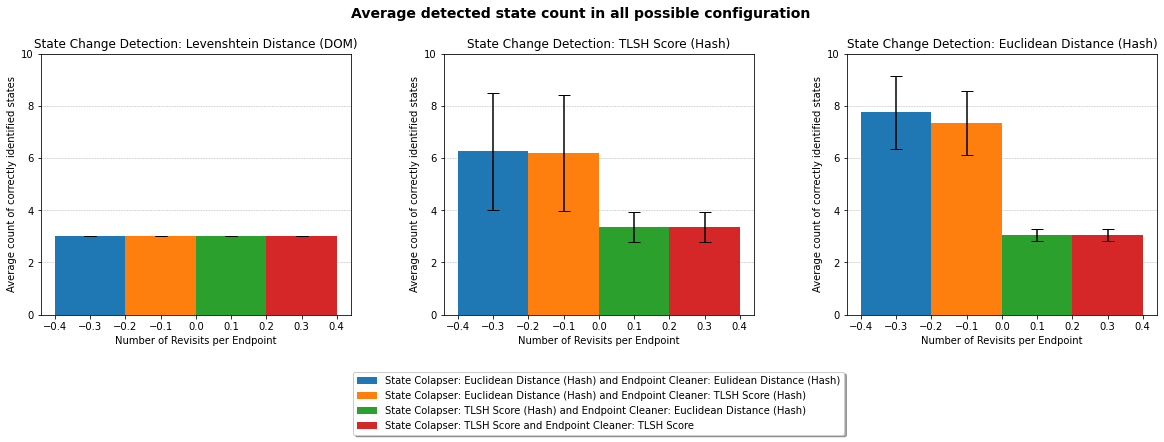

In [20]:
plot_mean_data_clustering_based(data=all_runs_df, 
               column='state_count', 
               y_lim=10,
               bar_offset=0.04,
               title='Average detected state count in all possible configuration')

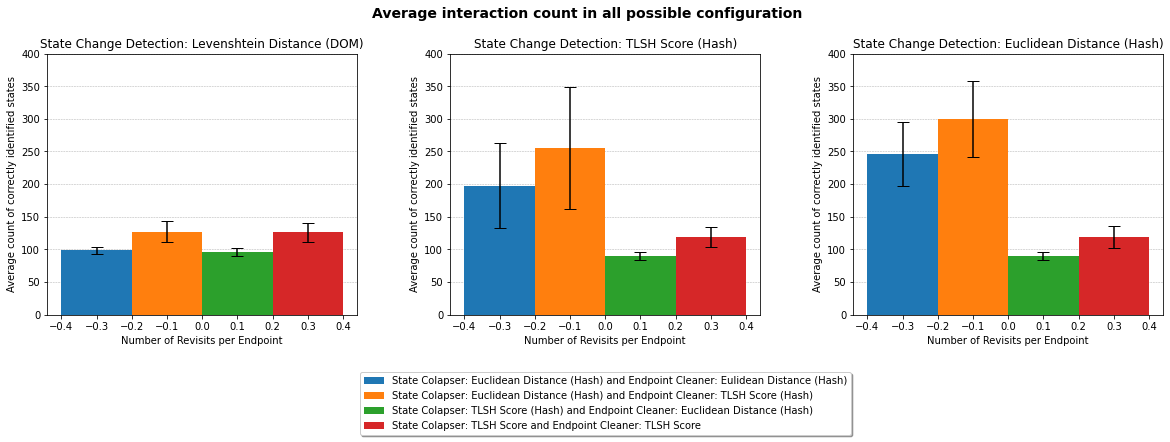

In [21]:
plot_mean_data_clustering_based(data=all_runs_df, 
               column='interaction_count',
               y_lim=400,
               bar_offset=0.04,
               title='Average interaction count in all possible configuration')

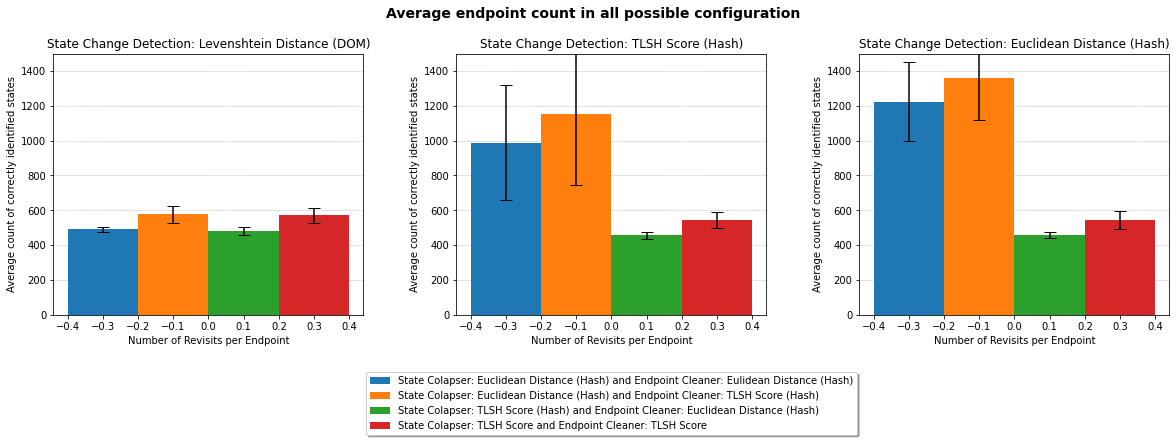

In [22]:
plot_mean_data_clustering_based(data=all_runs_df, 
               column='endpoint_count',
               y_lim=1500,
               bar_offset=0.06,
               title='Average endpoint count in all possible configuration')

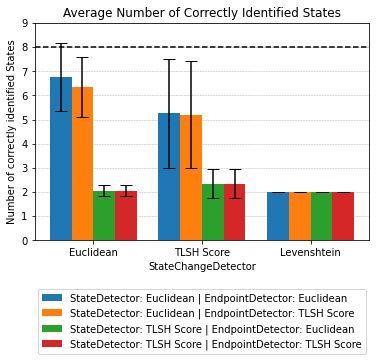

In [23]:
plot_mean_data_one_fig_clustering_based(data=all_runs_df,
               column='correct_states_count',
               y_lim=9,
               bar_offset=0.04,
               title='Average Number of Correctly Identified States',
               y_label='Number of correctly identified States') 

## Calculate the impact of each module

In [24]:
mean_values_scd = calculate_mean_data(all_runs_df, 'correct_states_count','StateChangeDetector' ,'ClusteringBased.StateChangeDetector')
diff_scd = max(mean_values_scd)-min(mean_values_scd)

In [25]:
mean_values_sc = calculate_mean_data(all_runs_df, 'correct_states_count','StateCollapser' ,'ClusteringBased.StateCollapser')
mean_values_sc.pop(0)
diff_sc = max(mean_values_sc)-min(mean_values_sc)

In [26]:
mean_values_ec = calculate_mean_data(all_runs_df, 'correct_states_count','Endpoint_Cleaner' ,'ClusteringBased.EndpointCleaner')
mean_values_ec.pop(0)
diff_ec = max(mean_values_ec)-min(mean_values_ec)

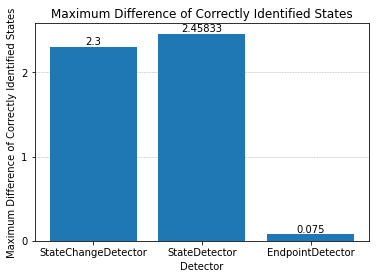

In [27]:
fig, ax = plt.subplots()
title = "Maximum Difference of Correctly Identified States"
ax.set_title(title)
ax.set_xlabel("Detector")
ax.set_ylabel("Maximum Difference of Correctly Identified States")
x_values = [0,1,2]
ax.grid(linestyle = '--', linewidth = 0.5, axis = 'y', zorder=0)
ax.set_xticks(x_values, ["StateChangeDetector", "StateDetector", "EndpointDetector"])
ax.set_yticks([0,1,2,3])
bars = ax.bar(x_values,(diff_scd, diff_sc, diff_ec), zorder=3)
ax.bar_label(bars)
plt.savefig(f'{title.lower().replace(" ", "_")}.svg', bbox_inches='tight', format="svg")

# Basic Endpoint Detector Experiments

In [28]:
experiments_dir = root_directory + '/Basic ED Experiments'
all_runs_eval = gen_for_all(experiments_dir, range(run_count))

100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.70it/s]


In [29]:
# Creating one big picture

# Data generation

columns = [
    "EndpointDetector", "EndpointDetector_DF", "EndpointDetector_DT",
    "Endpoint_Cleaner", "Endpoint_Cleaner_DF", "Endpoint_Cleaner_DT",
    "StateChangeDetector", "StateChangeDetector_DF", "StateChangeDetector_DT",
    "StateCollapser", "StateCollapser_DF", "StateCollapser_DT",
]

all_runs_list = []
columns_combined = all_runs_eval['0'].columns.values.tolist() + columns
all_runs_df = pd.DataFrame(columns=columns_combined)
for run, eval_data in all_runs_eval.items():
    all_results_reshaped = pd.DataFrame(columns = columns_combined)
    for index, experiment in eval_data.iterrows():
        run_directory = f"{experiments_dir}/{run}"
        config, revisits = get_workers_info(run_directory, str(experiment.batch_name))
        config_reshaped = pandas.DataFrame(columns=columns_combined)
        tmp_dict = experiment.to_dict()
        for i, row in config.iterrows():
            tmp_dict[columns[i*3]] = row['Module']
            tmp_dict[columns[i*3+1]] = row['Distance Field']
            tmp_dict[columns[i*3+2]] = row['Distance Type']
        config_reshaped = config_reshaped.append(tmp_dict, ignore_index=True)
        all_results_reshaped = all_results_reshaped.append(config_reshaped, ignore_index=True)
    all_runs_list.append(all_results_reshaped)
    all_runs_df = all_runs_df.append(all_results_reshaped)

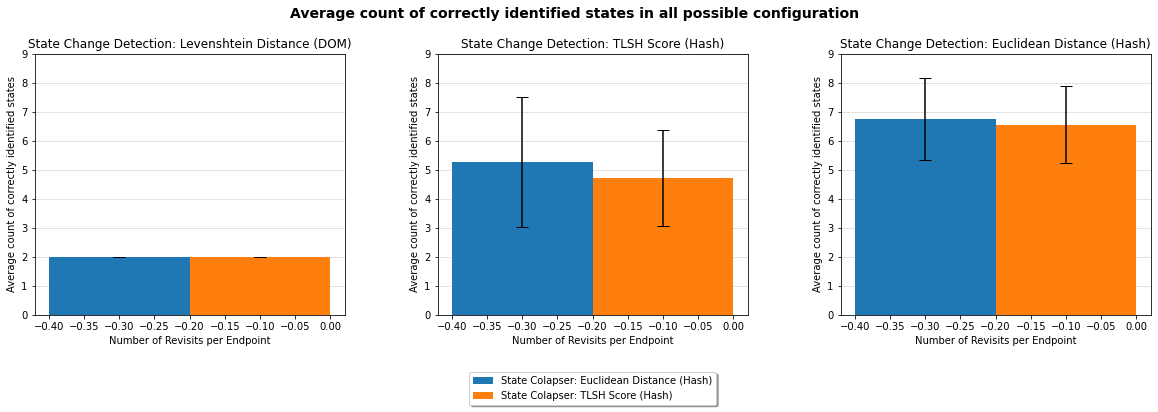

In [30]:
plot_mean_data_basic(data=all_runs_df, 
               column='correct_states_count', 
               y_lim=9,
               bar_offset=0.04,
               title='Average count of correctly identified states in all possible configuration')

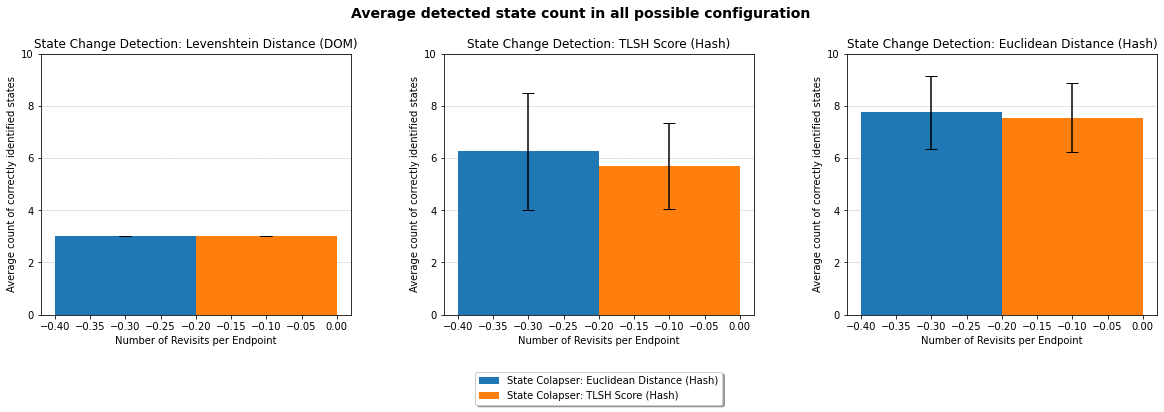

In [31]:
plot_mean_data_basic(data=all_runs_df, 
               column='state_count', 
               y_lim=10,
               bar_offset=0.04,
               title='Average detected state count in all possible configuration')

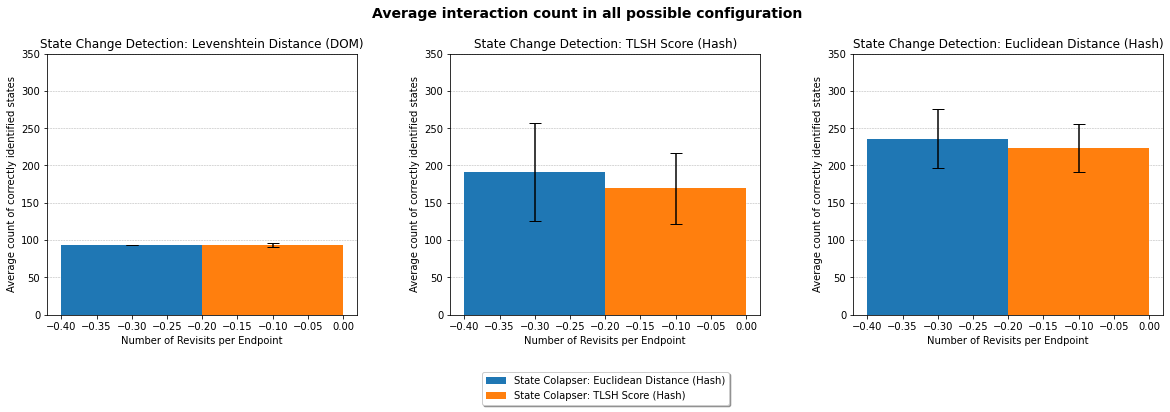

In [32]:
plot_mean_data_basic(data=all_runs_df, 
               column='interaction_count',
               y_lim=350,
               bar_offset=0.04,
               title='Average interaction count in all possible configuration')

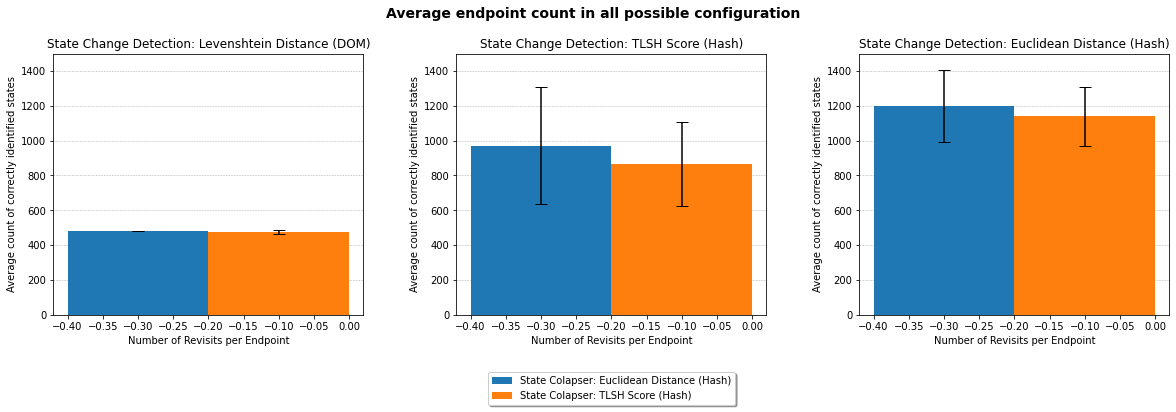

In [33]:
plot_mean_data_basic(data=all_runs_df, 
               column='endpoint_count',
               y_lim=1500,
               bar_offset=0.06,
               title='Average endpoint count in all possible configuration')

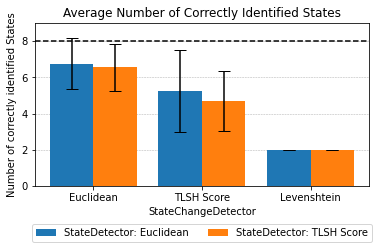

In [34]:
plot_mean_data_one_fig_basic(data=all_runs_df,
               column='correct_states_count',
               y_lim=9,
               bar_offset=0.04,
               title='Average Number of Correctly Identified States',
               y_label='Number of correctly identified States') 